### Plotting the data



Check the estimates from the UN, which are stored in the column `un`:

1.  Save the column in a `Series` `un` (normalized to billions).
2.  Display the end of the column with `show` and `tail`:



In [1]:
un = table2.un / 1e9
print(show(un.tail()))

un
Year          
2012  7.080072
2013  7.162119
2014  7.243784
2015  7.349472
2016       NaN

Estimates from the UN after 2015 are missing. We can plot both the US
and the UN estimates with the `Series.plot` function. We first plot each
curve on its own, and then we'll put them in a function to plot them
side by side.

Plot the US `census` data:



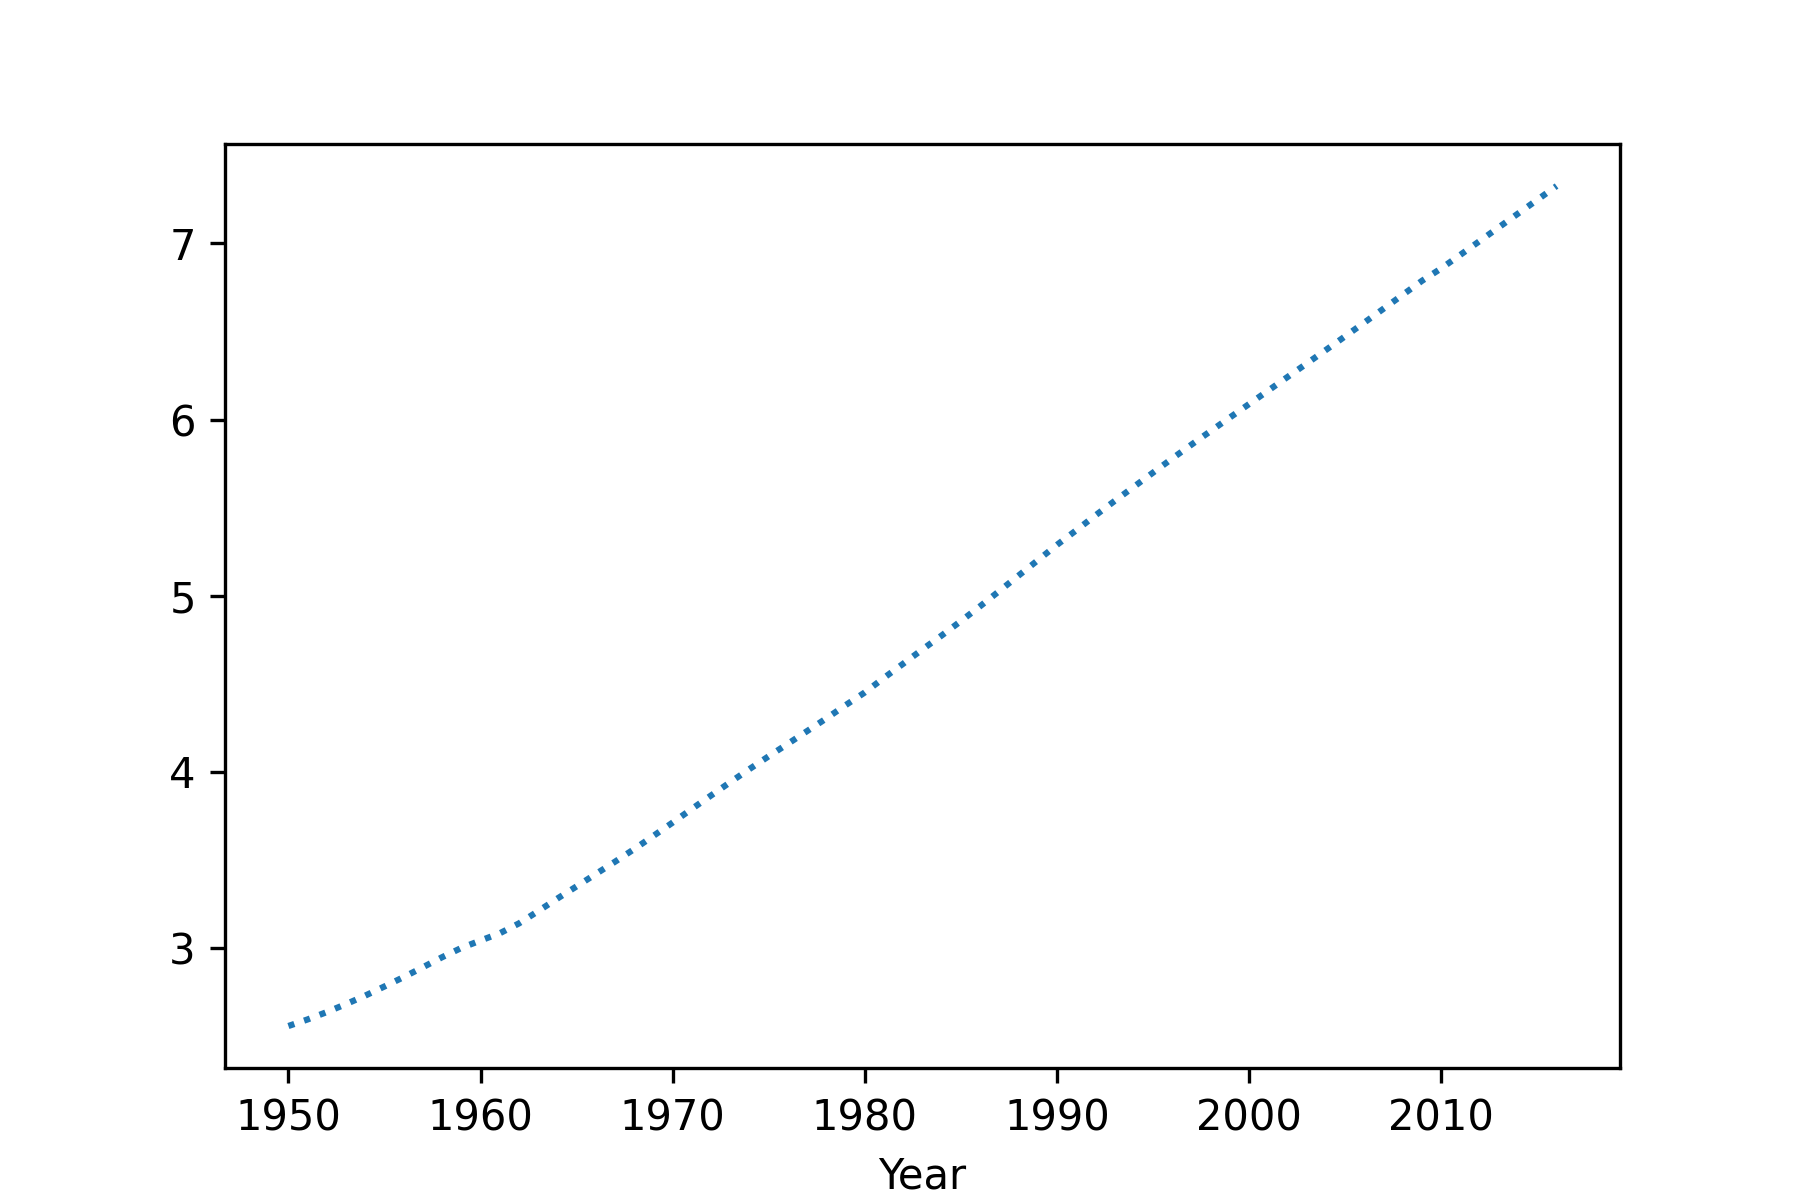

In [1]:
import matplotlib.pyplot as plt
plt.clf()
census.plot(style=':', label='US Census')
plt.savefig("img/census.png")  # import matplotlib.pyplot as plt

Plot the UN DESA data in `un`:



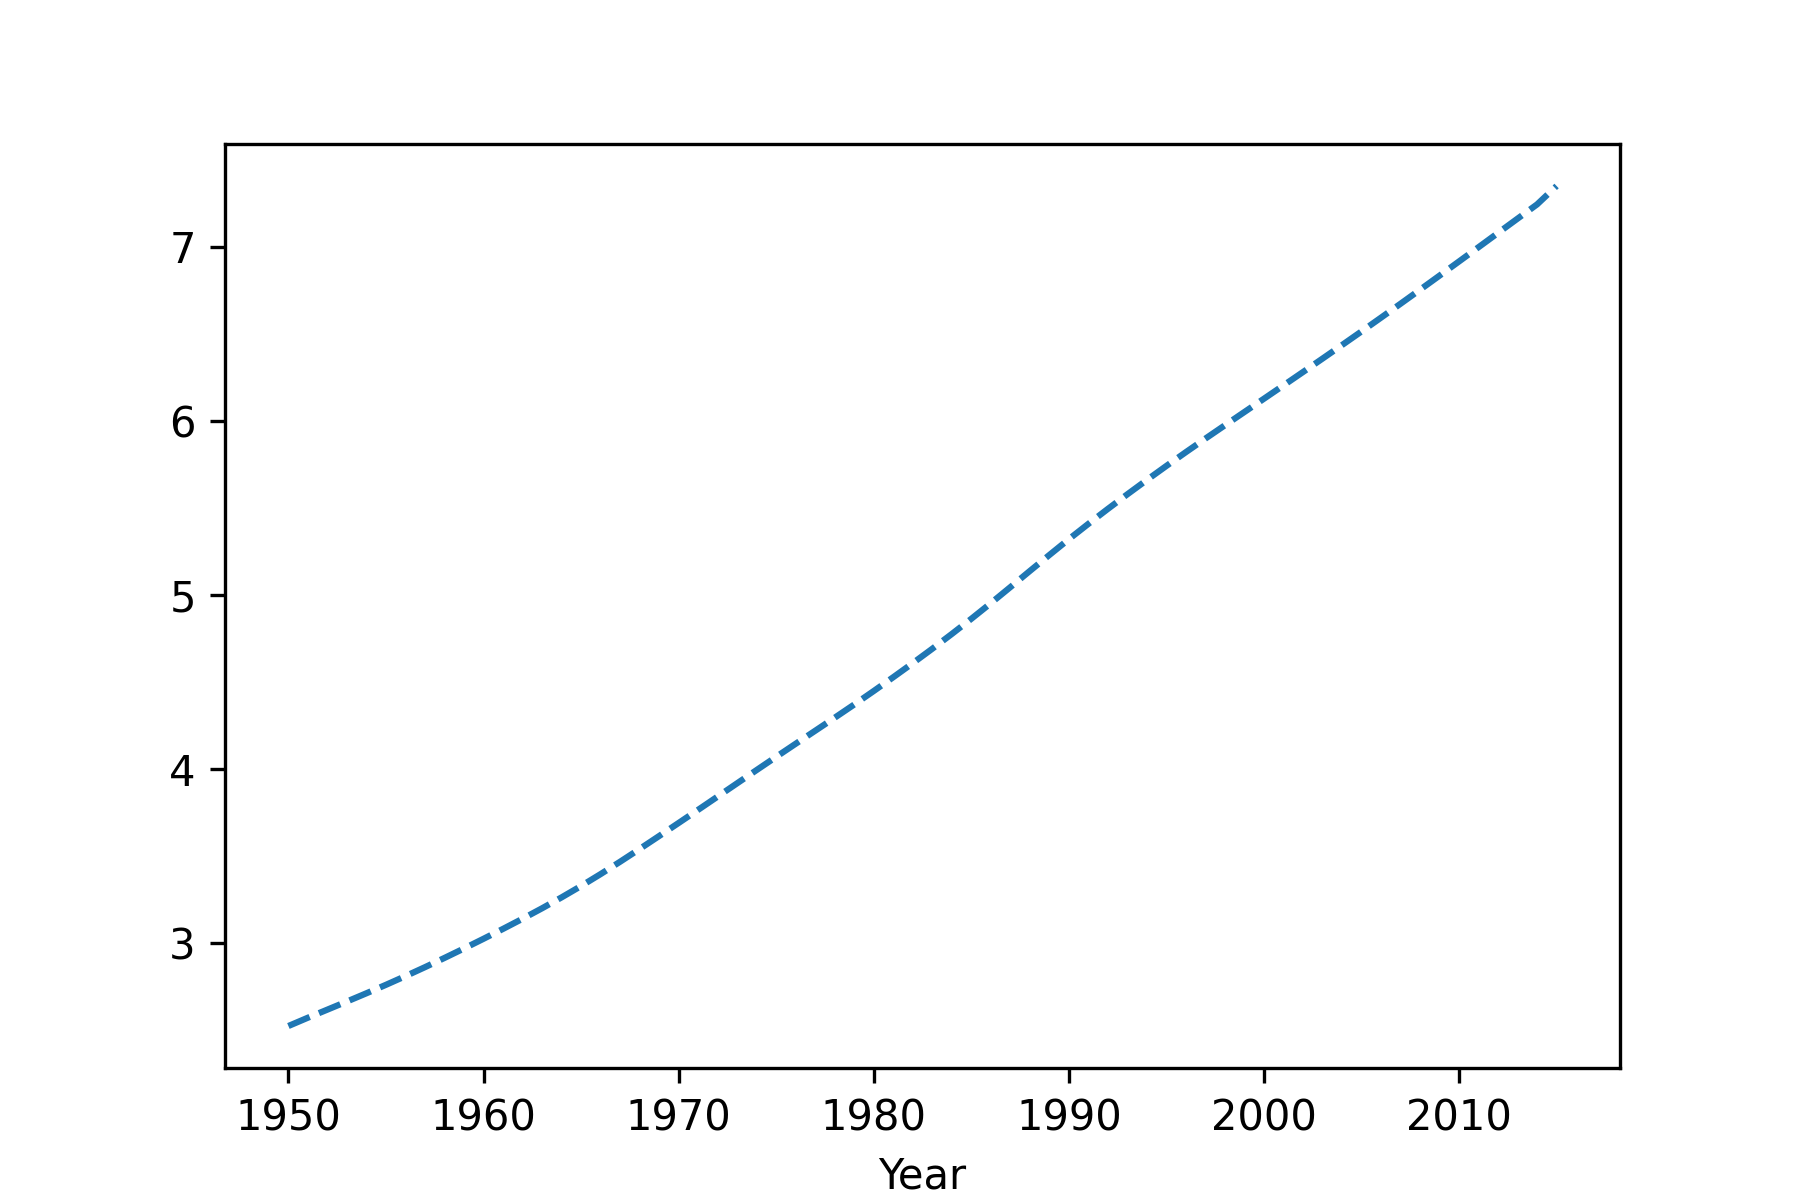

In [1]:
plt.clf()
un.plot(style='--', label='UN DESA')
plt.savefig("img/un.png")

Create a function to plot US `census` and UN DESA `un` data:



In [1]:
def plot_estimates():
    census.plot(style=':', label='US Census')
    un.plot(style='--', label='UN DESA')
    decorate(xlabel='Year', ylabel='World population [bn]')

Plot the data with a title:



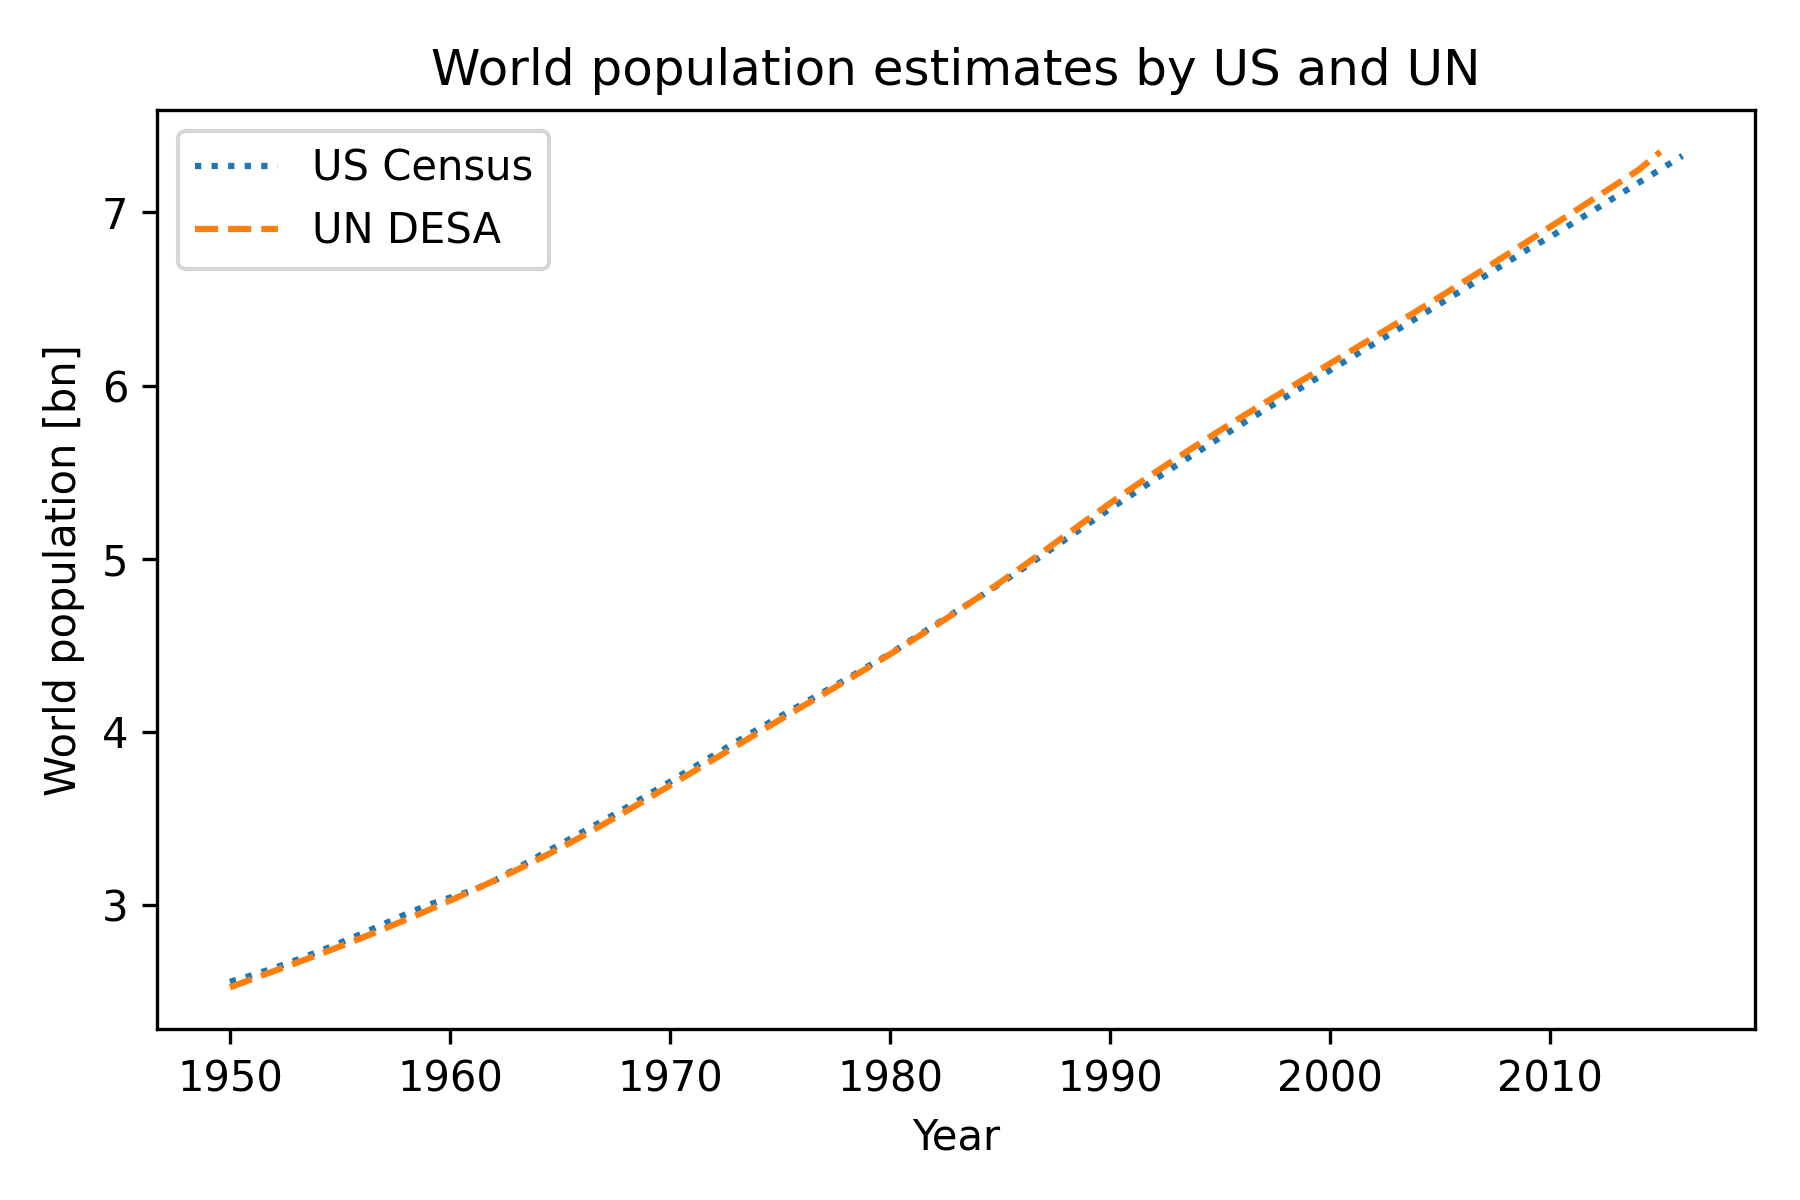

In [1]:
plt.clf()
plot_estimates()
decorate(title='World population estimates by US and UN')
plt.savefig("img/worldpop.png")  # import matplotlib.pyplot as plt

### Absolute and relative errors



As the plot showed, the estimates from the US and the UN differ
slightly. We can express the difference as *error*:

1.  The *absolute error* is the absolute value of the difference
    between the estimates.
2.  The *relative error* is obtained by normalizing the error using
    the size of the estimates.
3.  When we compute an error, absolute or relative, for every two
    estimates of two `Series` (state vectors), we're interested in
    statistical properties, too, e.g. the *average* and the *maximum*.

To compute absolute errors, `import` the function `abs` from `numpy`.



In [1]:
from numpy import abs

Compute the difference of the errors across both `Series`, take the
absolute with `abs` and display the `tail` end of the resulting `Series`:



In [1]:
# compute difference of un and census errors
diff = un - census

# take the absolute
abs_error = abs(diff)

# display the tail of the result
print(abs_error.tail())

Year
2012    0.066201
2013    0.069991
2014    0.073816
2015    0.101579
2016         NaN
dtype: float64

Notice how we're getting `NaN` in the last row because the computer
cannot guess the value of a missing number.

How can we check if any values are `NaN`?



In [1]:
print(tables[2].un.isnull())  # checks for all values
print(tables[2].un.isnull().values.any()) # are any values NaN?

#+begin_example
Year
1950    False
1951    False
1952    False
1953    False
1954    False
        ...  
2012    False
2013    False
2014    False
2015    False
2016     True
Name: un, Length: 67, dtype: bool
True
#+end_example

What does the second function chain do?

1.  Extracts `tables[2]` (dataframe)
2.  Extracts `un` `Series` column from the dataframe
3.  `is.null` Checks for `NaN` and returns Boolean vector
4.  `values.any` prints the values whenever its input is `True`.

Compute the `mean` absolute error after getting the function `mean` from
`numpy`.



In [1]:
from numpy import mean

print(mean(abs_error))

0.029034508242424265

On average the estimates differ by 0.029 bn (29 mio) people.



In [1]:
print(mean(abs_error) * 1e9)

29034508.242424265

Compute the *maximum absolute error* with the `numpy` function `max`.



In [1]:
from numpy import max

print(max(abs_error))

The estimates differ at worst by 0.1 bn (100 mio) people. How much is
that relative to the total numbers?

To compute *relative error* (relative to the estimates), we divide the
absolute error by the estimates (and multiply by 100 for percent):



In [1]:
rel_error = 100 * abs_error / census
print(rel_error.tail())

Year
2012    0.943860
2013    0.986888
2014    1.029514
2015    1.401500
2016         NaN
dtype: float64

In 2015, the difference is about 1.4%. This is also the maximum:



In [1]:
print(max(rel_error))

1.4014999251669376

The average relative error summarizes these results:



In [1]:
print(mean(rel_error))

0.5946585816022846

A mean relative error of 0.6% is not bad (what does it depend on how
bad it really is? Why do we compute errors?)

You could have computed the relative error by dividing by the UN
estimates, too. In general, use the better estimator if there's
one. If you don't know which one's better, take the larger one
(`census`) so that the computed errors are more conservative (larger).



### Modeling population growth



We want to predict world population growth over the next 50 years:

1.  develop a model that describes population growth.
2.  fit the model to the historical data.
3.  use the model to generate predictions.

The data look as if population growth has been close to linear
since 1960 or so. We comput the total growth in 1950 to 2016:



In [1]:
total_growth = census[2016] - census[1950]
print(total_growth)

4.768368055

Hardcoding data into a model is not recommended. We can
generalize by referring to labels instead of years:



In [1]:
t_0 = census.index[0]  # happens to be 1950 for our dataset
print(t_0)

1950

Store the last element in `t_end`:



In [1]:
t_end = census.index[-1]
print(t_end)

2016

The difference between `t_0` and `t_end` is the elapsed time between
them:



In [1]:
elapsed_time = t_end - t_0
print(elapsed_time)

66

We use our generalized times to select the population `p_0` at the
beginning and `p_end` at the end of the interval:



In [1]:
p_0 = census[t_0]
p_end = census[t_end]

We compute the `total_growth` using these numbers:



In [1]:
total_growth = p_end - p_0
print(total_growth)

4.768368055

What is the average annual growth?



In [1]:
annual_growth = total_growth / elapsed_time
print(annual_growth)

0.07224800083333333

From 1950 to 2016, the world population grew by about 0.07
billion people per average.



### Simulating population growth



Simulating means setting a starting state and evolving the
starting state by a function of time.

Simulation population growth means starting with the observed
population in 1950 (`p_0`), and adding `annual_growth` each year.

To store the `results` we use a labelled array, a `TimeSeries`:



In [1]:
from modsim import TimeSeries
results = TimeSeries()

We initialize the `TimeSeries` with `p_0`:



In [1]:
results[t_0] = p_0

`show` what the `TimeSeries` looks like so far:



In [1]:
from modsim import show

print(show(results))

Quantity
Time          
1950  2.557629

Now we set the rest of the values by simulating annual growth in
a loop over the whole `range` of values from `t_0` to `t_end`:



In [1]:
for t in range(t_0, t_end):
    results[t+1] = results[t] + annual_growth

We can now plot the historical data alongside our model:



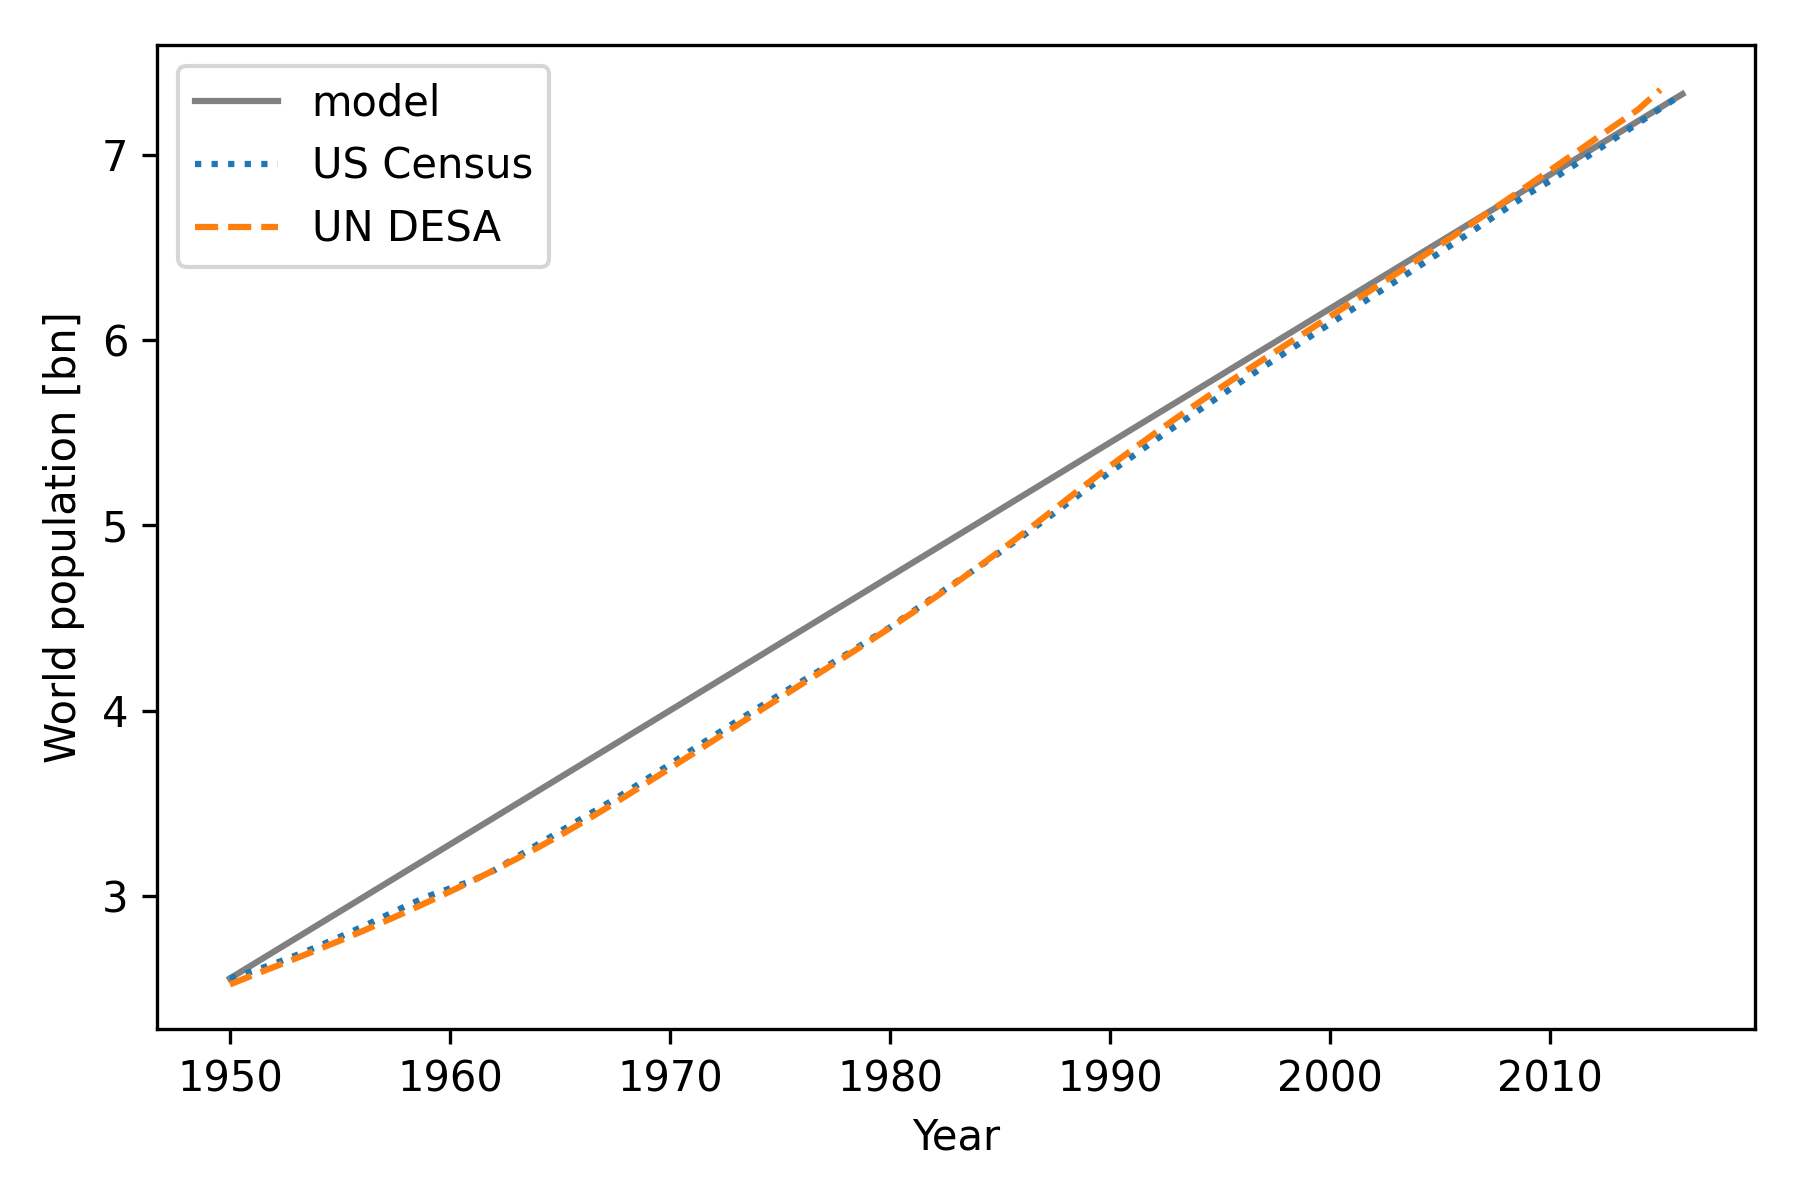

In [1]:
from modsim import decorate

plt.clf()
results.plot(color='gray', label='model')
plot_estimates()
plt.savefig("img/popgrowth.png")

The model looks pretty accurate after about 1990.



### Summary



Concepts:

-   Population growth need not be constant from year to year
-   Changes in population are determined by the current population
-   The model predicts constant population growth ad infinitum

Code:

-   `pandas`: library for `DataFrame` and `Series` objects
-   Webscraping HTML tables into a `list` of `DataFrame` objects
-   Transforming the column headers of a `DataFrame`
-   Accessing `Series` `index` and `values`
-   Checking for missing values `NaN` with `isnull`
-   Computing absolute and relative statistical errors

